# Event embedding representation

Author: Xinyu Zhao, Arizona State University 

Email: xzhao119@asu.edu

This notebook illustrates the  embedding rerpesentation of aviation accident events

## Code Requirements

Following is the package requirements for the notebook
- Pytorch 1.4.0
- catboost 0.23
- xgboost 1.0.2
- sklearn 0.21.3

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import torch
import numpy as np 
from util import *
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load data

In [4]:
data_group = pd.read_pickle("data/data_group.pkl")

occurrence_code_corpus = np.load("data/occurrence_code_corpus.npy")
subject_code_corpus = np.load("data/subject_code_corpus.npy")
phase_code_corpus = np.load("data/phase_code_corpus.npy")

subj_to_occurrence_dict = pd.read_pickle("data/subj_to_occurrence_dict.pkl")
occurrence_to_subj_dict = pd.read_pickle("data/occurrence_to_subj_dict.pkl")
phase_to_occurrence_dict = pd.read_pickle("data/phase_to_occurrence_dict.pkl")
occurrence_to_phase_dict = pd.read_pickle("data/occurrence_to_phase_dict.pkl")
index_phase = [len(x) for x in phase_to_occurrence_dict.values()].index(max([len(x) for x in phase_to_occurrence_dict.values()]))
index_occurrence = [len(x) for x in occurrence_to_subj_dict.values()].index(max([len(x) for x in occurrence_to_subj_dict.values()]))


subject_size = len(subject_code_corpus)
phase_size = len(phase_code_corpus)
occurrence_size = len(occurrence_code_corpus)
isRNN = True
batch_size = 1
device = torch.device('cuda:1')
if isRNN:
    embedding_dim = 30  # Embedding of each word
    hidden_dim = 30      #Final hidden dimension that is used for prediction
    num_layer = 2        # Number of layers 
    latent_dim = 30     # Latend dimension 

    model =  RNNModel(phase_size, occurrence_size, subject_size, embedding_dim, latent_dim, num_layer, batch_size, hidden_dim, device).to(device)
    hierarchical_softmax = HierarchicalSoftmax(hidden_dim, phase_to_occurrence_dict, occurrence_to_subj_dict,subj_to_occurrence_dict,device).to(device)
    hierarchical_softmax.load_state_dict(torch.load('model/hierarchical_softmax_rnn_20200801_1227_rnn__19.sav'))
    model.load_state_dict(torch.load('model/model_rnn_20200801_1227_rnn__19.sav'))
else:
    embedding_dim = 30  # Embedding of each word
    hidden_dim = 30      #Final hidden dimension that is used for prediction

    num_layer = 2        # Number of layers 
    latent_dim = 30     # Latend dimension 
    model = SequentialPrediction(phase_size,occurrence_size,subject_size, embedding_dim, batch_size,hidden_dim, device)
    hierarchical_softmax = HierarchicalSoftmax(hidden_dim, phase_to_occurrence_dict, occurrence_to_subj_dict,subj_to_occurrence_dict,device).to(device)
    hierarchical_softmax.load_state_dict(torch.load('model/hierarchical_softmax_sequential_20200801_1226_nornn__19.sav'))
    model.load_state_dict(torch.load('model/model_sequential_20200801_1226_nornn__19.sav'))

# Visualize phase embedding 

In [5]:
phases = ['STANDING', 'TAXI', 'TAKEOFF', 'CLIMB', 'CRUISE', 'DESCENT', 'APPROACH', 'LANDING', 'MANEUVERING', 'HOVER']
marker_list = [".", "v", "8", "x", "s", "H",",", "^", "<", ">"]
phase_code_corpus[phase_code_corpus=='']=111
phase_list = np.array([int(x) for x in phase_code_corpus])
phase_index = {}
phase_index['STANDING'] = (phase_list>=500)&(phase_list<=505)
phase_index['TAXI'] = (phase_list>=510)&(phase_list<=514)
phase_index['TAKEOFF'] = (phase_list>=520)&(phase_list<=523)
phase_index['CLIMB'] = (phase_list>=530)&(phase_list<=531)
phase_index['CRUISE'] = (phase_list>=540)&(phase_list<=541)
phase_index['DESCENT'] = (phase_list>=550)&(phase_list<=553)
phase_index['APPROACH'] = (phase_list>=560)&(phase_list<=569)
phase_index['LANDING'] = (phase_list>=570)&(phase_list<=576)
phase_index['MANEUVERING'] = (phase_list>=580)&(phase_list<=583)
phase_index['HOVER'] = (phase_list>=590)&(phase_list<=592)

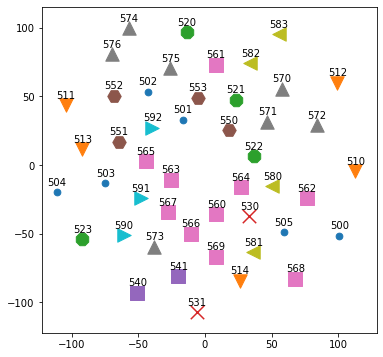

<Figure size 432x288 with 0 Axes>

In [6]:
word_vectors = model.word_embedding_phase.weight.cpu().detach().numpy()
model_tsne = TSNE(n_components = 2, perplexity=23, early_exaggeration=1,learning_rate=200, n_iter=10000, random_state=0)
tsne_data = model_tsne.fit_transform(word_vectors)
NUM_PHASES = len(phases)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
for i in range(NUM_PHASES):
    index = phase_index[phases[i]]
    ax.scatter(tsne_data[index,0], tsne_data[index,1], marker=marker_list[i], s=180)
    for word, (x,y) in zip(phase_code_corpus[index], tsne_data[index]):
        ax.text(x-7, y+5 , word)
plt.show()
plt.tight_layout()

# Visualize occurrence embedding 

In [7]:
occurrences = ['MALFUNCTION', 'FIRE/EXPLOSION', 'GEAR', 'LOSS OF ENGINE POWER', 'ON GROUND/WATER COLLISION', 'IN FLIGHT COLLISION', 'LOSS OF CONTROL', 'MIDAIR COLLISION', 'NOSE', 'PROPELLER']
marker_list = [".", "v", "8", "x", "s", "H",",", "^", "<", ">"]
occurrence_code_corpus[occurrence_code_corpus=='']=111
occurrence_list = np.array([int(x) for x in occurrence_code_corpus])
occurrence_index = {}
occurrence_index['MALFUNCTION'] = (occurrence_list>=130)&(occurrence_list<=132)
occurrence_index['FIRE/EXPLOSION'] = (occurrence_list>=170)&(occurrence_list<=172)
occurrence_index['GEAR'] = (occurrence_list>=190)&(occurrence_list<=198)
occurrence_index['LOSS OF ENGINE POWER'] = (occurrence_list>=350)&(occurrence_list<=353)
occurrence_index['ON GROUND/WATER COLLISION'] = (occurrence_list>=310)&(occurrence_list<=330)
occurrence_index['IN FLIGHT COLLISION'] = (occurrence_list>=220)&(occurrence_list<=232)
occurrence_index['LOSS OF CONTROL'] = (occurrence_list>=250)&(occurrence_list<=260)
occurrence_index['MIDAIR COLLISION'] = (occurrence_list>=270)&(occurrence_list<=271)
occurrence_index['NOSE'] = (occurrence_list>=290)&(occurrence_list<=300)
occurrence_index['PROPELLER'] = (occurrence_list>=360)&(occurrence_list<=370)

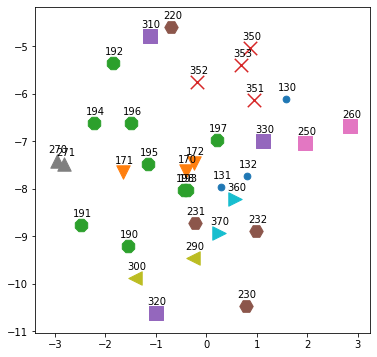

<Figure size 432x288 with 0 Axes>

In [9]:
word_vectors = model.word_embedding_occurrence.weight.cpu().detach().numpy()
model_tsne = TSNE(n_components = 2, perplexity=23, early_exaggeration=1,learning_rate=200, n_iter=10000, random_state=0)
tsne_data = model_tsne.fit_transform(word_vectors)
NUM_OCCUR = 10
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
for i in range(NUM_OCCUR):
    index = occurrence_index[occurrences[i]]
    ax.scatter(tsne_data[index,0], tsne_data[index,1], marker=marker_list[i], s=180)
    for word, (x,y) in zip(occurrence_code_corpus[index], tsne_data[index]):
        ax.text(x-0.16, y+0.18 , word)
plt.show()
plt.tight_layout()

# Meaning of occurrence/phase codes

In [10]:
mypath = "/home/xinyu/Project/data/aviation_ntsb/raw_data"
DataDict = pd.read_csv(mypath+'/eADMSPUB_DataDictionary.csv')
DataDict[DataDict['Column']=='Phase_of_Flight']

,Category of Data,Table,Column,ct_name,code_iaids,meaning,Data Type eADMS,Length eADMS,short_desc,Question_Def,Code meaning,typeofchange,Change_notes
697,Pre eADMS coding,Occurrences,Phase_of_Flight,NaN,504,Standing - engine(s) not operating,int,NaN,Phase of Flight,All occurrences include information about the ...,NaN,NaN,NaN
999,Pre eADMS coding,Occurrences,Phase_of_Flight,NaN,514,Taxi - aerial,int,NaN,Phase of Flight,All occurrences include information about the ...,NaN,NaN,NaN
1000,Pre eADMS coding,Occurrences,Phase_of_Flight,NaN,530,Climb,int,NaN,Phase of Flight,All occurrences include information about the ...,NaN,NaN,NaN
1001,Pre eADMS coding,Occurrences,Phase_of_Flight,NaN,542,Maneuvering - holding (IFR),int,NaN,Phase of Flight,All occurrences include information about the ...,NaN,NaN,NaN
1002,Pre eADMS coding,Occurrences,Phase_of_Flight,NaN,560,Approach,int,NaN,Phase of Flight,All occurrences include information about the ...,NaN,NaN,NaN
1003,Pre eADMS coding,Occurrences,Phase_of_Flight,NaN,565,Go-around (VFR),int,NaN,Phase of Flight,All occurrences include information about the ...,NaN,NaN,NaN
1004,Pre eADMS coding,Occurrences,Phase_of_Flight,NaN,569,Missed approach (IFR),int,NaN,Phase of Flight,All occurrences include information about the ...,NaN,NaN,NaN
1017,Pre eADMS coding,Occurrences,Phase_of_Flight,NaN,573,Landing - aborted,int,NaN,Phase of Flight,All occurrences include information about the ...,NaN,NaN,NaN
1018,Pre eADMS coding,Occurrences,Phase_of_Flight,NaN,581,Maneuvering - aerial application,int,NaN,Phase of Flight,All occurrences include information about the ...,NaN,NaN,NaN
1019,Pre eADMS coding,Occurrences,Phase_of_Flight,NaN,592,Hover - out of ground effect,int,NaN,Phase of Flight,All occurrences include information about the ...,NaN,NaN,NaN


In [14]:
mypath = "/home/xinyu/Project/data/aviation_ntsb/raw_data"
DataDict = pd.read_csv(mypath+'/eADMSPUB_DataDictionary.csv')
DataDict[DataDict['Column']=='Occurrence_Code']

,Category of Data,Table,Column,ct_name,code_iaids,meaning,Data Type eADMS,Length eADMS,short_desc,Question_Def,Code meaning,typeofchange,Change_notes
671,Pre eADMS coding,Occurrences,Occurrence_Code,NaN,100,Abrupt maneuver,int,NaN,Type of Occurrence,Multiple occurrences can be used to describe n...,NaN,NaN,NaN
672,Pre eADMS coding,Occurrences,Occurrence_Code,NaN,132,Rotor failure/malfunction,int,NaN,Type of Occurrence,Multiple occurrences can be used to describe a...,NaN,NaN,NaN
673,Pre eADMS coding,Occurrences,Occurrence_Code,NaN,171,Fire,int,NaN,Type of Occurrence,Multiple occurrences can be used to describe a...,NaN,NaN,NaN
674,Pre eADMS coding,Occurrences,Occurrence_Code,NaN,191,Main gear collapsed,int,NaN,Type of Occurrence,Multiple occurrences can be used to describe a...,NaN,NaN,NaN
683,Pre eADMS coding,Occurrences,Occurrence_Code,NaN,195,Other gear collapsed,int,NaN,Type of Occurrence,Multiple occurrences can be used to describe a...,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2773,Pre eADMS coding,Occurrences,Occurrence_Code,NaN,390,Undershoot,int,NaN,Type of Occurrence,Multiple occurrences can be used to describe a...,NaN,NaN,NaN
2774,Pre eADMS coding,Occurrences,Occurrence_Code,NaN,400,Undetermined,int,NaN,Type of Occurrence,Multiple occurrences can be used to describe a...,NaN,NaN,NaN
2775,Pre eADMS coding,Occurrences,Occurrence_Code,NaN,410,Vortex turbulence encountered,int,NaN,Type of Occurrence,Multiple occurrences can be used to describe a...,NaN,NaN,NaN
2776,Pre eADMS coding,Occurrences,Occurrence_Code,NaN,420,Missing aircraft,int,NaN,Type of Occurrence,Multiple occurrences can be used to describe a...,NaN,NaN,NaN
